# Compare the difference in elevation between DEM and Icesat-2 Data
REMA  

In [1]:
%matplotlib inline

In [2]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (12, 7), 'font.size': 10})

from shapely.geometry import Polygon, Point
import hvplot
import geoviews as gv

import xarray as xr

import rasterio as rio
import hvplot.pandas
import hvplot.xarray

In [3]:
#base_region = #'REMA'

#data5: region_19_victoria_land  region_21_mbl_north  region_22_mbl_central     region_24_ctam
#data4: region_01_subantarctic_islands region_02_peninsula_north region_03_peninsula_south
#project: R:\REMA\region_20_ross_shelf\strips_unf\2m

#region = ''#'hma_2019jun26' #'region_20_ross_shelf'
region = 'region_03_peninsula_south'#'region_34_alaska_north'#'region_31_alaska_south'#'region_19_victoria_land' 
# folder = f'W:/icesat2/rema/{region}'
# folder = f'D:/icesat2/EarthDEM/{region}'
folder = f'/fs/byo/howat-data5/icesat2/rema/{region}'
strips = os.listdir(folder)
# Select a particular satellite, WV03 for example
# strips = [strip for strip in strips if strip.startswith('WV03')]
len(strips)

102

In [4]:
fig_folder = '/home/yadav.111/figs_icesat/ATL06'
os.path.exists(fig_folder)

True

In [5]:
# selected ones 90, 
# alternative 70
strip = strips[90]
# strip = 'W1W1_20190208_10200100827B7600_1020010082EBD500_2m_lsf'#'W2W3_20190313_103001008F927000_104001004BC46B00_2m_lsf'
icesat2_path = f'{folder}/{strip}'
# os.listdir(icesat2_path)
# outline = gpd.read_file('D:/wspace/icesat2/urmia/outline.shp')
# outline = gpd.read_file('D:/wspace/icesat2/tanana/outline.shp')
# icesat2_path = 'D:/wspace/icesat2/alaska3a'
# icesat2_path = f'/fs/project/howat.4/icesat2/greenland_ATL06'
files = os.listdir(f'{icesat2_path}')
# outline = gpd.read_file(f'{icesat2_path}/strip_outline.shp')
# outline.plot(column='seg_id', alpha=.5), plt.title(f'{strip}');

hdf_files = [f for f in files if f.endswith('.h5')]
shp_files = [f for f in files if f.endswith('.shp') and 'ATL06' in f]
csv_files = [f for f in files if f.endswith('.csv') and 'ATL06' in f]
# To pick the largest granule for visualization only
sz_list = [os.path.getsize(f'{icesat2_path}/{hdf}') for hdf in hdf_files]
idx = sz_list.index(max(sz_list)) #largest index
print('No of shp files',len(shp_files), len(hdf_files))
# print(outline.area)

fname = shp_files[idx].split('.shp')[0]

# Load ATL08 parsed data
df = pd.read_csv(f'{icesat2_path}/{fname}.csv', parse_dates=True)
gdf = gpd.read_file(f'{icesat2_path}/{fname}.shp', parse_dates=True)
# Pick only the good quality data [verify if zero or one means good]
df = df[df.q_flag==0]
gdf = gdf[gdf.q_flag==0]
df = df.reset_index(drop=True)
gdf = gdf.reset_index(drop=True)
#Also reset index
gtls = list(df.strip.unique())
print(len(df), gtls)
# gv.tile_sources.ESRI * gdf.hvplot.points(geo=True, color='strip', alpha=0.7, width=500, height=700, hover=['strip', 'h_te_media'])

No of shp files 4 4
25970 ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']


In [6]:
# gtl = gtls[1]
base = gv.tile_sources.ESRI
gtracks = gdf.hvplot.points(geo=True, color='strip', s=10, alpha=0.7, width=500, height=600, hover=['strip', 'h_te_media'])
terrain_scatter = df.hvplot(y='lat', x='h_li', kind='scatter', width=350, height=600, by='strip', s=5, alpha=.9, xlabel='meters').relabel('Elevation') # by='strip', 
# canopy_scatter = df[df.strip==gtl].hvplot(y='lat', x='h_max_canopy_abs', kind='scatter', width=350, height=650, color='green', s=10, alpha=.9, title=f'Elevation ({gtl})', xlabel='meters').relabel('canopy')
fig1 = (base*gtracks + terrain_scatter).cols(2)
# fig1 = base*gtracks + terrain_scatter*canopy_scatter
# hvplot.save(fig1, f'{fig_folder}/{fname}.png')
fig1

:Layout
   .Overlay.I           :Overlay
      .WMTS.I   :WMTS   [Longitude,Latitude]
      .Points.I :Points   [Longitude,Latitude]   (strip)
   .NdOverlay.Elevation :NdOverlay   [strip]
      :Scatter   [h_li]   (lat)

In [7]:
hvplot.save(fig1, f'{fig_folder}/{fname}.png')

In [8]:
fname

'processed_ATL06_20181214173812_11770112_002_01'

## Choose a DEM strip for Analysis

In [9]:
## Now get the DEM (Rema for example)

#dir_prefix = '/fs/byo/howat-data5' #data4, 5 'D:' 'V:'
dir_prefix = '/fs/byo/howat-data4' #'/fs/project/howat.4' #/REMA/region_20_ross_shelf
dem_folder = f'{dir_prefix}/REMA/{region}/strips_unf/2m/{strip}'
tifs = [tif for tif in os.listdir(dem_folder) if tif.endswith('.tif')]
tifs

['WV03_20181122_1040010045590A00_10400100455FBA00_2m_lsf_seg1_dem.tif',
 'WV03_20181122_1040010045590A00_10400100455FBA00_2m_lsf_seg1_ortho.tif',
 'WV03_20181122_1040010045590A00_10400100455FBA00_2m_lsf_seg1_dem_10m.tif',
 'WV03_20181122_1040010045590A00_10400100455FBA00_2m_lsf_seg1_matchtag.tif',
 'WV03_20181122_1040010045590A00_10400100455FBA00_2m_lsf_seg1_bitmask.tif',
 'WV03_20181122_1040010045590A00_10400100455FBA00_2m_lsf_seg1_dem_browse.tif']

In [10]:
[tif for tif in os.listdir(dem_folder) if tif.endswith('_dem.tif')]

['WV03_20181122_1040010045590A00_10400100455FBA00_2m_lsf_seg1_dem.tif']

In [11]:
# Can have one or more DEMs depending on how it was produced
dem_tif = [tif for tif in os.listdir(dem_folder) if tif.endswith('_dem.tif')]
ortho_tif = [tif for tif in os.listdir(dem_folder) if tif.endswith('_ortho.tif')][0]
print(dem_tif)
dem_tif = dem_tif[0] #Choose one DEM (or better find a way to merge; but this will also significantly increase the size of data)
dem_tif

['WV03_20181122_1040010045590A00_10400100455FBA00_2m_lsf_seg1_dem.tif']


'WV03_20181122_1040010045590A00_10400100455FBA00_2m_lsf_seg1_dem.tif'

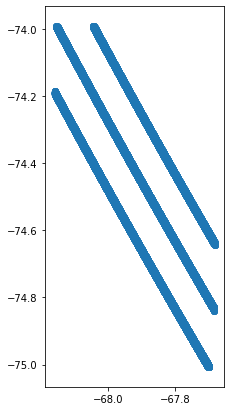

In [12]:
gdf.plot()

In [13]:
import georasters as grs
# Get the DEM
dem = grs.from_file(f'{dem_folder}/{dem_tif}')
def getPixVal(geom):
    #dem.map_pixel(x, y)
    coords = geom.coords[0]
    x, y = coords
    return(dem.map_pixel(x, y))

In [14]:
proj4 = '+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs' #rema 
# proj4 = '+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs' #arcticDEM
# gdf = gdf.to_crs({'init': 'epsg:4326'}) #change to lat/longitude
gdf2 = gdf.to_crs(proj4) #Without projecting to same crs as DEM, cant extract elevation from dEM

gdf2['dem'] = gdf2.geometry.apply(getPixVal)
# gdf = gdf.iloc[6:-10]
gdf2['dif'] = gdf2.h_li-gdf2.dem

In [15]:
# These are edge of DEMs so basically no data
gdf2 = gdf2[gdf2.dem!=0] 

In [16]:
# dem.plot()

In [17]:
gdf.crs, gdf2.crs

({'init': 'epsg:4326'},
 '+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs')

In [18]:
# use xarray only for visualization
da = xr.open_rasterio(f'{dem_folder}/{dem_tif}')
# da = xr.open_rasterio(f'{dem_folder}/{ortho_tif}')
nodata_value = da.attrs['nodatavals'][0]
da.data[da.data==nodata_value] = np.nan
print(nodata_value)

-9999.0


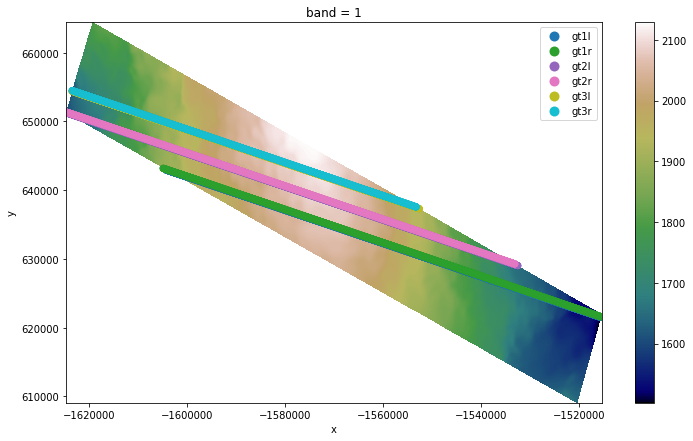

In [19]:
# To plot icesat and dem together, convert to common coordinate system
proj4 = '+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs' #rema 
gdf_proj = gdf.to_crs(proj4)
ax = gdf_proj.plot(column='strip', legend=True)
da.sel(band=1).plot.imshow(ax=ax, cmap='gist_earth')
# plt.title('ATL08 over the REMA DEM')

In [20]:
gdf2 = gdf2.reset_index(drop = True)

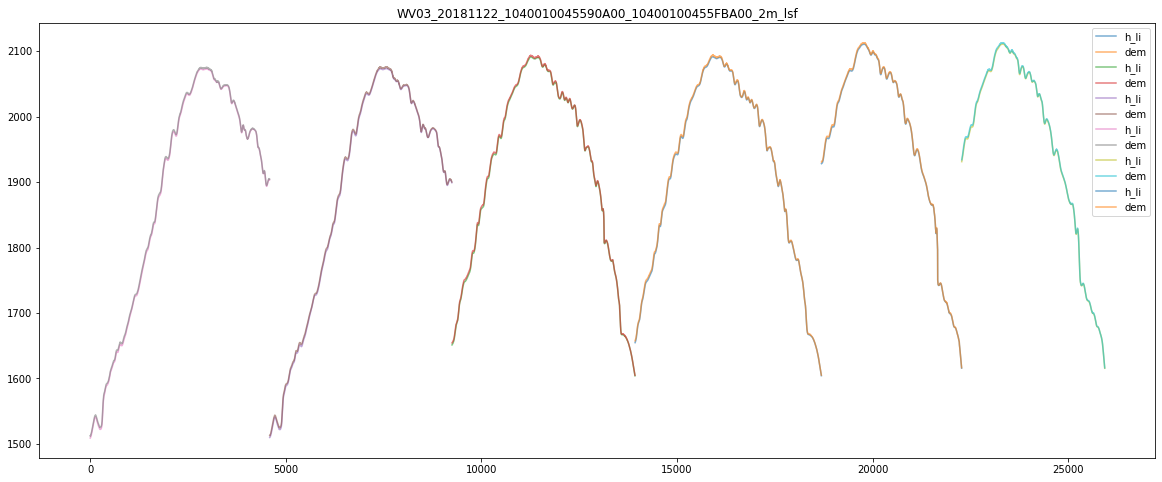

In [21]:
gtls = list(gdf2.strip.value_counts().index) #['gt1l', 'gt1r','gt2l', 'gt2r', 'gt3l','gt3r']
# gtl = gtls[2]
fig, ax = plt.subplots(figsize=(20, 8))
for gtl in gtls:
    gdf2[gdf2.strip==gtl][['h_li', 'dem']].iloc[1:-1].plot(style='-', alpha=.6, title=strip, ax=ax); #, ax=ax

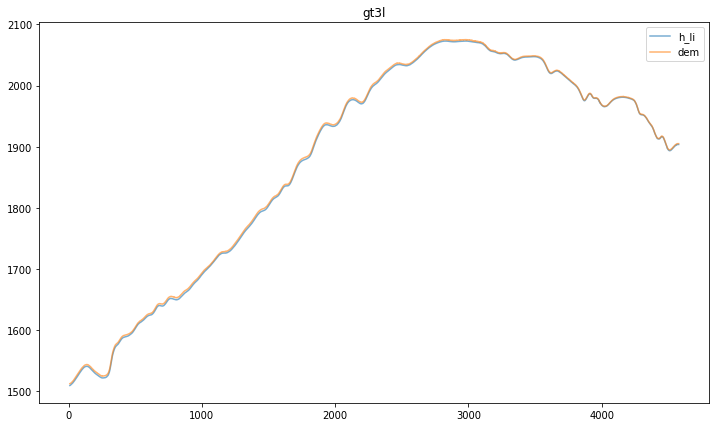

In [22]:
gdf2[gdf2.strip=='gt1l'].reset_index()[['h_li', 'dem']].iloc[10:-10].plot(style='-', alpha=.6, title=gtl)

In [23]:
# len(gtls)
gtls

['gt2r', 'gt2l', 'gt1r', 'gt1l', 'gt3r', 'gt3l']

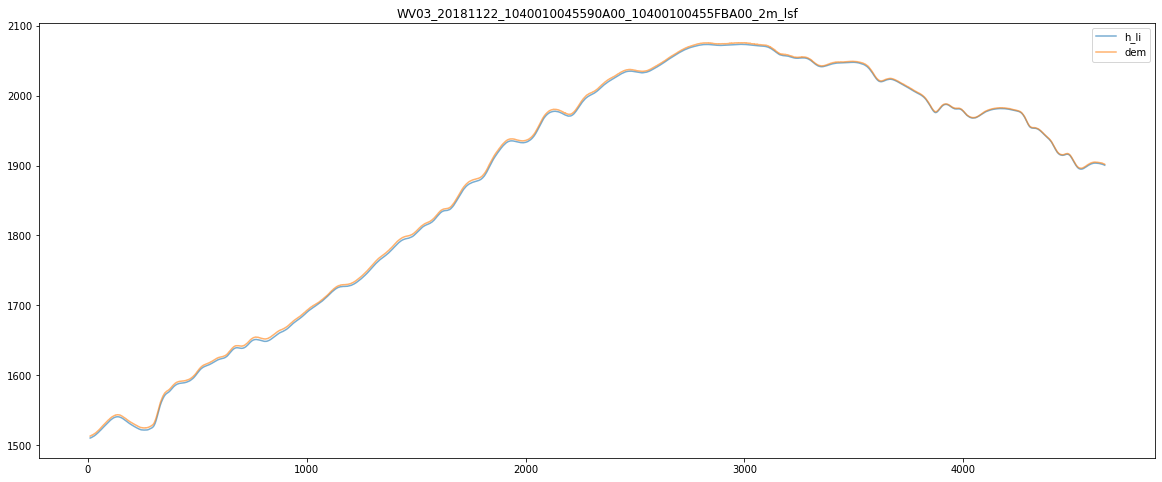

In [24]:
# gdf[['h_li', 'dem']].plot()
fig, ax = plt.subplots(figsize=(20, 8))
# gdf2[gdf2.strip=='gt1l'][['h_li', 'dem']].reset_index(drop=True).iloc[10:-10].plot(style='-', alpha=.6, title=strip, ax=ax); #, ax=ax
gdf2[gdf2.strip=='gt1r'][['h_li', 'dem']].reset_index(drop=True).iloc[10:-10].plot(style='-', alpha=.6, title=strip, ax=ax); #, ax=ax

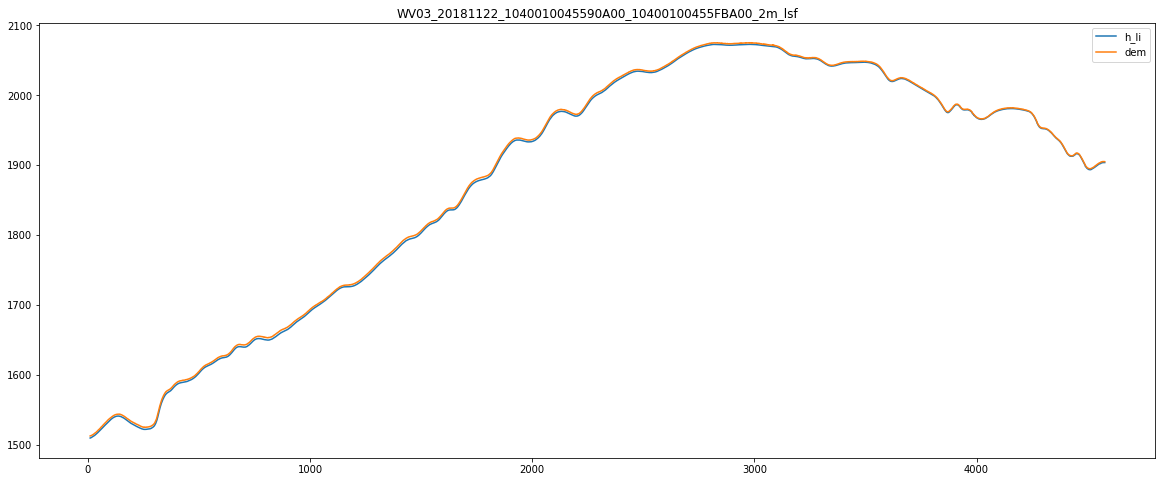

In [25]:
fig, ax = plt.subplots(figsize=(20, 8))
gdf2[gdf2.strip=='gt1l'][['h_li', 'dem']].reset_index(drop=True).iloc[10:-10].plot(style='-', title=strip, ax=ax); #, ax=ax
# gdf[gdf.strip=='gt1r'][['h_li', 'dem']].reset_index(drop=True).iloc[10:-10].plot(style='-', alpha=.6, title=strip, ax=ax); #, ax=ax

In [26]:
# gdf0[gdf0.strip=='gt1l'].reset_index(drop=True)

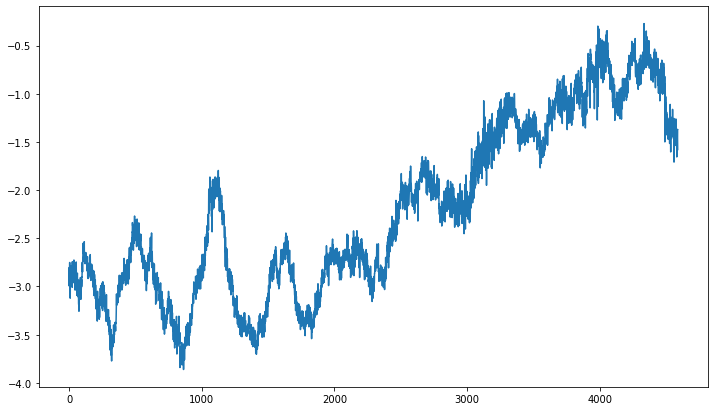

In [27]:
gdf2[gdf2.strip=='gt1l'].dif.plot()

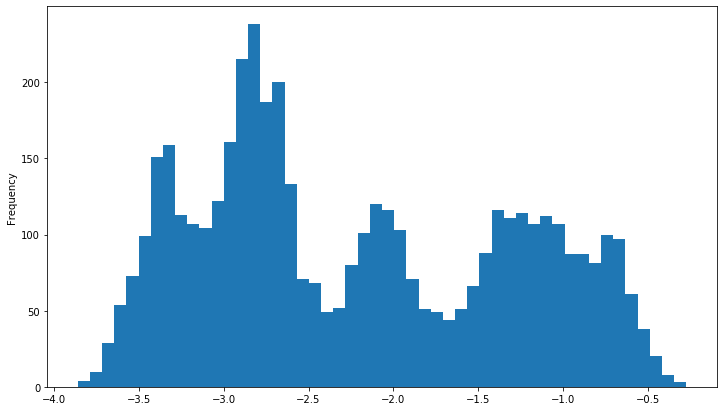

In [28]:
gdf2[gdf2.strip=='gt1l'].dif.plot(kind='hist', bins=50)

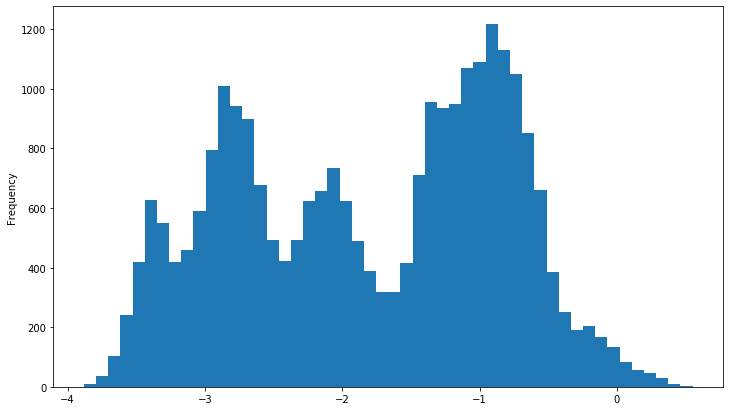

In [29]:
gdf2.dif.plot(kind='hist', bins=50)

In [30]:
gdf2.strip.value_counts()

gt2r    4763
gt2l    4679
gt1r    4658
gt1l    4588
gt3r    3657
gt3l    3584
Name: strip, dtype: int64

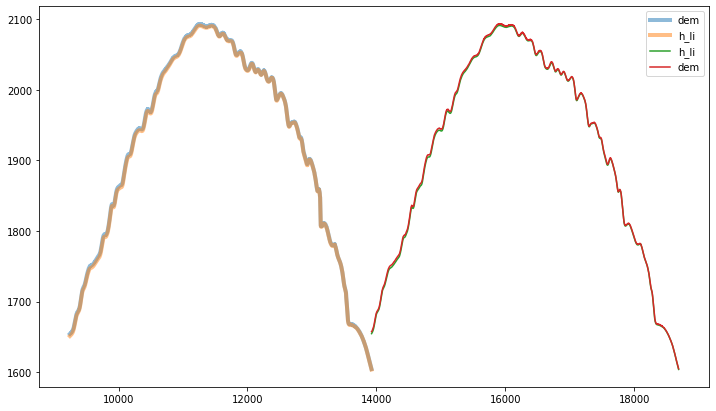

In [40]:
gtl = 'gt2'
ax = gdf2[gdf2.strip==f'{gtl}l'][['dem','h_li']].plot(lw=4, alpha=.5)
# gdf2[gdf2.strip==f'{gtl}r'][['h_li', 'dem']].plot(ax = ax)

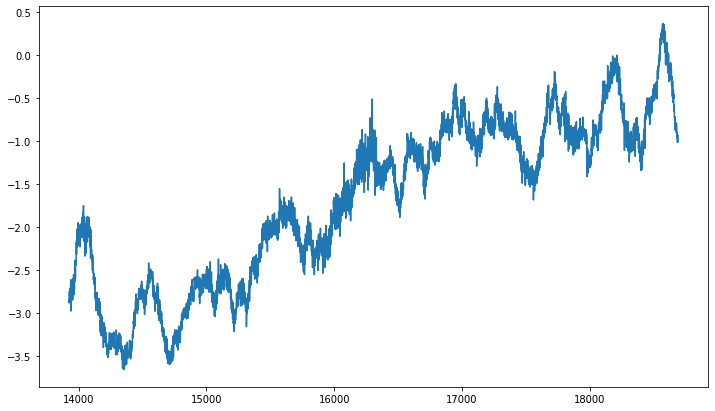

In [32]:
gdf2[gdf2.strip==f'{gtl}r'].dif.plot()

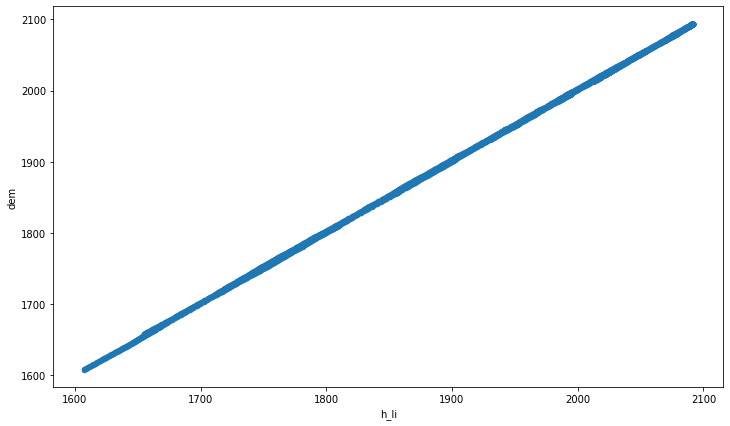

In [33]:
gdf2[gdf2.strip==f'{gtl}r'][['h_li', 'dem']].iloc[2:-10].plot(kind='scatter', x=0, y=1)